In [55]:
import pandas as pd
import numpy as np
import re

from nltk import word_tokenize
from nltk.stem.snowball import RussianStemmer
from sklearn.feature_extraction.text import HashingVectorizer

from scipy import sparse
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('../dataset/RoboMed/new_train.csv')
test_df = pd.read_csv('../dataset/RoboMed/new_test.csv')

In [3]:
train_df.Revisit.value_counts()

1    234576
0     48510
Name: Revisit, dtype: int64

In [4]:
def explain_diagnosis_code(series):
    regex = '([A-Z])(\d\d)(?:.(\d\*?))?'
    prefixes = ['группа_', 'номер_', 'подномер_']
    def get_explanation(string):
        matches = re.findall(regex, string)
        if len(matches) == 0:
            return 'неизвестный_диагноз'
        return [prefix + token for prefix, token in zip(prefixes, matches[0])]
    return series.apply(lambda string: ' '.join(get_explanation(string)))

In [5]:
train_df['Общее состояние'] = train_df['Общее состояние'].fillna('общее_состояние_неизвестно')
train_df['аллергия'] = train_df['аллергия'].fillna('аллергии_неизвестны')
train_df['Анамнез заболевания'] = train_df['Анамнез заболевания'].fillna('нет_анамнеза')
train_df['Внешний осмотр'] = train_df['Внешний осмотр'].fillna('нет_осмотра')
train_df['Типичные_жалобы'] = train_df['Типичные_жалобы'].fillna('типичные_жалобы_неизвестны')
train_df['Типичные_услуги'] = train_df['Типичные_услуги'].fillna('типичные_услги_неизвестны')
train_df['Типичные_источники_рекламы'] = train_df['Типичные_источники_рекламы'].fillna('типичные_источники_рекламы_неизвестны')
train_df['Код_диагноза'] = explain_diagnosis_code(train_df['Код_диагноза'])

test_df['Общее состояние'] = test_df['Общее состояние'].fillna('общее_состояние_неизвестно')
test_df['аллергия'] = test_df['аллергия'].fillna('аллергии_неизвестны')
test_df['Анамнез заболевания'] = test_df['Анамнез заболевания'].fillna('нет_анамнеза')
test_df['Внешний осмотр'] = test_df['Внешний осмотр'].fillna('нет_осмотра')
test_df['Типичные_жалобы'] = test_df['Типичные_жалобы'].fillna('типичные_жалобы_неизвестны')
test_df['Типичные_услуги'] = test_df['Типичные_услуги'].fillna('типичные_услги_неизвестны')
test_df['Типичные_источники_рекламы'] = test_df['Типичные_источники_рекламы'].fillna('типичные_источники_рекламы_неизвестны')
test_df['Код_диагноза'] = explain_diagnosis_code(test_df['Код_диагноза'])

In [6]:
train_dataframe, valid_dataframe = train_test_split(train_df, test_size=0.1,
                                                    stratify=train_df.Revisit, random_state=42)

In [7]:
def concat_text_features(df):
    features = (
        df['Код_диагноза'].str.replace('.', '#') + ' • ' +
        df['Диагноз'] + ' • ' +
        'Возраст_' + df['Возраст'].astype(str) + ' • ' +
        'Пол_' + df['Пол'].astype(str) + ' • ' +
        df['Общее состояние'] + ' • ' +
        df['аллергия'] + ' • ' +
        df['Анамнез заболевания'] + ' • ' +
        df['Внешний осмотр'] + ' • ' +
        df['Типичные_жалобы'] + ' • ' +
        df['Типичные_услуги'] + ' • ' +
        df['Типичные_источники_рекламы']
    )
    return features.str.lower().str.replace('\n', '').apply(lambda string: re.sub(r"([.\!?,'/()\-№:;])", ' \\1 ', string))

In [8]:
text_train = concat_text_features(train_dataframe)
text_valid = concat_text_features(valid_dataframe)
text_test = concat_text_features(test_df)

In [137]:
stemmer = RussianStemmer()

def clean_string(string: str):
    string = string.lower()
    string = re.sub("['\";()]", '', string)
    string = re.sub('[\n\-/\\*,\.&]', ' ', string)
    string = ' '.join(stemmer.stem(word) for word in word_tokenize(string))
    return string

In [9]:
text_clean_train = text_train #.apply(clean_string)
text_clean_valid = text_valid #.apply(clean_string)
text_clean_test = text_test #.apply(clean_string)

In [78]:
n_features = 60000
word_counts_vectorizer = HashingVectorizer(n_features=n_features,
                                           analyzer='word', ngram_range=(1, 1),
                                           stop_words=['•', '|'])
char_ngrams_counts_vectorizer = HashingVectorizer(n_features=n_features,
                                                  analyzer='char_wb', ngram_range=(3, 3))

word_counts_train = word_counts_vectorizer.fit_transform(text_clean_train)
word_counts_valid = word_counts_vectorizer.transform(text_clean_valid)
word_counts_test = word_counts_vectorizer.transform(text_clean_test)

char_ngrams_counts_train = char_ngrams_counts_vectorizer.fit_transform(text_clean_train)
char_ngrams_counts_valid = char_ngrams_counts_vectorizer.transform(text_clean_valid)
char_ngrams_counts_test = char_ngrams_counts_vectorizer.transform(text_clean_test)

In [79]:
features_train = sparse.hstack([word_counts_train, char_ngrams_counts_train], format='csr')
features_valid = sparse.hstack([word_counts_valid, char_ngrams_counts_valid], format='csr')
features_test = sparse.hstack([word_counts_test, char_ngrams_counts_test], format='csr')

In [101]:
clf = LogisticRegression(C=0.3, penalty='l2', class_weight='balanced', n_jobs=-1, solver='lbfgs')

In [102]:
clf.fit(features_train, train_dataframe.Revisit)

LogisticRegression(C=0.3, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [103]:
# 0.5 0.706
print(roc_auc_score(valid_dataframe.Revisit, clf.predict_proba(features_valid)[:, 1]))

0.7062839748734295


In [104]:
print(roc_auc_score(train_dataframe.Revisit, clf.predict_proba(features_train)[:, 1]))

0.7308061088644865


In [36]:
submission = pd.read_csv('/root/dataset/RoboMed/sample_submission.csv')
submission.proba = clf.predict_proba(features_test)[:, 1]
# submission.proba = (submission.proba > 0.391215).astype(int)
submission.to_csv('submission_lr_everything.csv', index=False)

In [105]:
def read_pred(filename):
    with open(filename) as file:
        lines = file.readlines()
        y_pred = np.array([float(line.split()[1]) if line.split()[0] == '__label__1' else 1 - float(line.split()[1])
                           for line in lines])
    return y_pred

In [106]:
y_pred_valid = read_pred('y_pred_valid.txt')
y_pred_test = read_pred('y_pred_test.txt')

0.6122448979591836  ->  0.7106502919932393


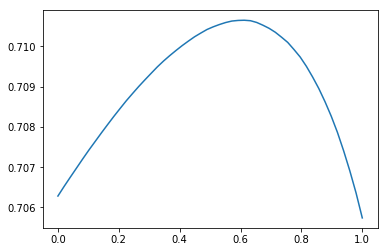

In [110]:
scores = np.array(
    [roc_auc_score(valid_dataframe.Revisit,
                        p * y_pred_valid + (1 - p) * clf.predict_proba(features_valid)[:, 1])
     for p in np.linspace(0, 1)])

plt.plot(np.linspace(0, 1), scores)
print(np.linspace(0, 1)[scores.argmax()], ' -> ', scores.max())

In [111]:
p = np.linspace(0, 1)[scores.argmax()]
blended_pred = p * y_pred_test + (1 - p) * clf.predict_proba(features_test)[:, 1]

In [112]:
y_pred_test = read_pred('y_pred_test.txt')
submission = pd.read_csv('/root/dataset/RoboMed/sample_submission.csv')
submission.proba = blended_pred
submission.to_csv('submission_blended.csv', index=False)